<a href="https://colab.research.google.com/github/gtseo0606/Learned/blob/main/Model%20Stacking%201(Kaggle).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

data_description.txt   scaled_X.npy	       test.csv   y.npy
sample_data	       scaled_y.npy	       train.csv
sample_submission.csv  submission_xgboost.csv  X.npy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("train.csv")

# Missing data

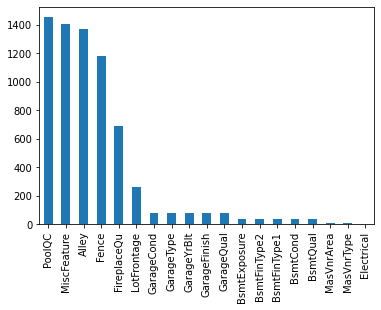

In [3]:
df_missing = df_train.isnull().sum()
df_missing = df_missing.sort_values(ascending=False) #정렬
df_missing[df_missing > 0].plot.bar()

In [4]:
df_missing = df_missing[df_missing > 0]
len(df_missing)

19

In [5]:
#missing data가 있는 feature 삭제
df_train = df_train.drop(df_missing.index.tolist(), axis = 1)
df_train

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,2,460,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,2,500,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,1,252,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,1,240,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [6]:
81 - len(df_missing)

62

In [7]:
len(df_train.columns)

62

In [8]:
#missing data 확인
df_train.isnull().sum().max()

0

In [9]:
numeric = [i for i in df_train.columns if df_train.dtypes[i] != 'object'] #숫자형
numeric.remove('Id')
numeric.remove('SalePrice')

categorical = [i for i in df_train.columns if df_train.dtypes[i] == 'object'] #분류형

# Categorical Data

In [10]:
df_order = pd.DataFrame()
feature_name = 'ExterQual' # 변수설정
df_order['val'] = df_train[feature_name].unique()
df_order

,val
0,Gd
1,TA
2,Ex
3,Fa


In [11]:
df_order.index = df_order.val
df_order

,val
val,
Gd,Gd
TA,TA
Ex,Ex
Fa,Fa


In [12]:
 df_train[[feature_name, 'SalePrice']]

,ExterQual,SalePrice
0,Gd,208500
1,TA,181500
2,Gd,223500
3,TA,140000
4,Gd,250000
...,...,...
1455,TA,175000
1456,TA,210000
1457,Ex,266500
1458,TA,142125


In [13]:
df_order['mean_price'] = df_train[[feature_name, 'SalePrice']].groupby(feature_name).mean()['SalePrice'] #요인별(Gd, TA, Ex 등) 그룹화
df_order

,val,mean_price
val,,
Gd,Gd,231633.510246
TA,TA,144341.313466
Ex,Ex,367360.961538
Fa,Fa,87985.214286


In [14]:
df_order = df_order.sort_values('mean_price') # 정렬
df_order

,val,mean_price
val,,
Fa,Fa,87985.214286
TA,TA,144341.313466
Gd,Gd,231633.510246
Ex,Ex,367360.961538


In [15]:
df_order['rank'] = range(1, len(df_order) + 1) #rank
df_order

,val,mean_price,rank
val,,,
Fa,Fa,87985.214286,1
TA,TA,144341.313466,2
Gd,Gd,231633.510246,3
Ex,Ex,367360.961538,4


In [16]:
df_order = df_order['rank'].to_dict() # 딕셔너리로
df_order

{'Ex': 4, 'Fa': 1, 'Gd': 3, 'TA': 2}

In [17]:
df_train[feature_name + '_rank'] = df_train.apply(lambda row: df_order[row[feature_name]], axis=1)

In [18]:
df_train['test'] = 0

In [19]:
df_train #원래변수 62 + ExterQual_rank + test = 64개

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,ExterQual_rank,test
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,3,0
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,2,0
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,3,0
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,2,0
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,2,460,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000,2,0
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,2,500,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000,2,0
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,1,252,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500,4,0
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,1,240,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125,2,0


In [20]:
# 함수로 만들기
category_maps = []

def add_rank_feature(feature_name, rank_feature_name):
  df_order = pd.DataFrame()
  df_order['val'] = df_train[feature_name].unique()
  df_order.index = df_order.val

  df_order['mean_price'] = df_train[[feature_name, 'SalePrice']].groupby(feature_name).mean()['SalePrice']
  df_order['rank'] = range(1, len(df_order) + 1)
  df_order = df_order['rank'].to_dict()

  category_maps.append(df_order)

  df_train[rank_feature_name] = df_train.apply(lambda row: df_order[row[feature_name]], axis=1)

In [21]:
rank_features = []
for feature_name in categorical:
  
  rank_feature_name = feature_name + '_rank'
  
  print(feature_name, '-->', rank_feature_name)

  add_rank_feature(feature_name, rank_feature_name)

  rank_features.append(rank_feature_name)

MSZoning --> MSZoning_rank
Street --> Street_rank
LotShape --> LotShape_rank
LandContour --> LandContour_rank
Utilities --> Utilities_rank
LotConfig --> LotConfig_rank
LandSlope --> LandSlope_rank
Neighborhood --> Neighborhood_rank
Condition1 --> Condition1_rank
Condition2 --> Condition2_rank
BldgType --> BldgType_rank
HouseStyle --> HouseStyle_rank
RoofStyle --> RoofStyle_rank
RoofMatl --> RoofMatl_rank
Exterior1st --> Exterior1st_rank
Exterior2nd --> Exterior2nd_rank
ExterQual --> ExterQual_rank
ExterCond --> ExterCond_rank
Foundation --> Foundation_rank
Heating --> Heating_rank
HeatingQC --> HeatingQC_rank
CentralAir --> CentralAir_rank
KitchenQual --> KitchenQual_rank
Functional --> Functional_rank
PavedDrive --> PavedDrive_rank
SaleType --> SaleType_rank
SaleCondition --> SaleCondition_rank


In [22]:
rank_features

['MSZoning_rank',
 'Street_rank',
 'LotShape_rank',
 'LandContour_rank',
 'Utilities_rank',
 'LotConfig_rank',
 'LandSlope_rank',
 'Neighborhood_rank',
 'Condition1_rank',
 'Condition2_rank',
 'BldgType_rank',
 'HouseStyle_rank',
 'RoofStyle_rank',
 'RoofMatl_rank',
 'Exterior1st_rank',
 'Exterior2nd_rank',
 'ExterQual_rank',
 'ExterCond_rank',
 'Foundation_rank',
 'Heating_rank',
 'HeatingQC_rank',
 'CentralAir_rank',
 'KitchenQual_rank',
 'Functional_rank',
 'PavedDrive_rank',
 'SaleType_rank',
 'SaleCondition_rank']

In [23]:
df_processed = df_train[rank_features + numeric]
df_processed

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008
1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007
2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008
3,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006
4,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007
1456,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010
1457,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010
1458,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010


In [24]:
df_processed['SalePrice'] = df_train['SalePrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_processed

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125


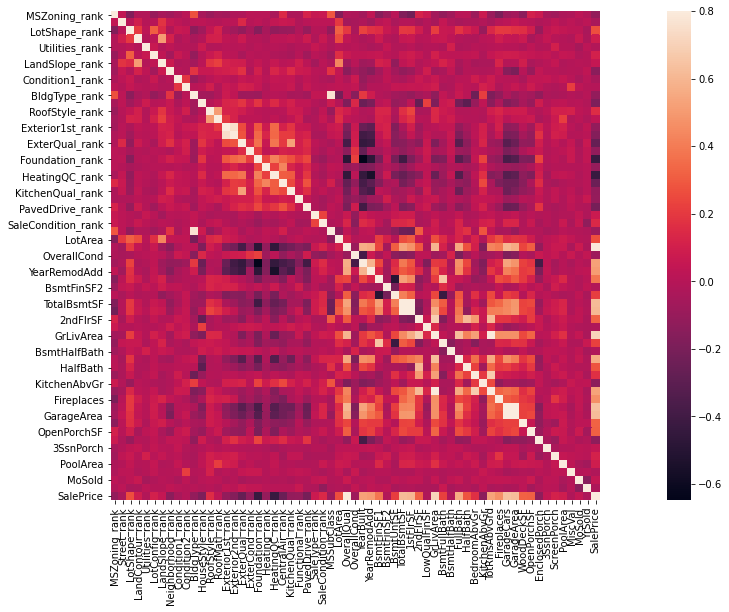

In [26]:
corrmat = df_processed.corr()
f, ax = plt.subplots(figsize = (24,9))

sns.heatmap(corrmat, vmax=0.8, square=True);

In [27]:
df_feature = corrmat.sort_values(by=['SalePrice'])['SalePrice']
df_feature

Foundation_rank   -0.429678
HeatingQC_rank    -0.427649
ExterQual_rank    -0.265015
CentralAir_rank   -0.251328
PavedDrive_rank   -0.208954
                     ...   
GarageArea         0.623431
GarageCars         0.640409
GrLivArea          0.708624
OverallQual        0.790982
SalePrice          1.000000
Name: SalePrice, Length: 61, dtype: float64

TODO
 1. 전처리 된 dataset으로 regression
 2. Change distribution of the label

# Train Test split

In [28]:
df_train

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,ExterQual_rank,test,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,...,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,...,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,2,0,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,1,2,1,1,1,2,1,1,1,1
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,...,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,1,0,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,...,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,2,0,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,1,3,1,2,1,1,1,1,1,2
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,...,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,1,0,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,...,0,40,0,0,0,0,0,8,2007,WD,Normal,175000,2,0,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,...,349,0,0,0,0,0,0,2,2010,WD,Normal,210000,2,0,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,1,2,1,3,1,2,2,1,1,1
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,...,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500,3,0,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,2,6,1,1,1,1,1,1,1,1
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,1078,0,0,1078,1,0,1,...,366,0,112,0,0,0,0,4,2010,WD,Normal,142125,2,0,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,1,2,1,2,1,1,1,1,1,1


In [29]:
from sklearn.model_selection import train_test_split

df_feature[-16:-1].index.tolist()

['OpenPorchSF',
 '2ndFlrSF',
 'WoodDeckSF',
 'BsmtFinSF1',
 'Fireplaces',
 'YearRemodAdd',
 'YearBuilt',
 'TotRmsAbvGrd',
 'FullBath',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'OverallQual']

In [30]:
X = df_processed[df_feature[-16:-1].index.tolist()]
y = df_processed['SalePrice']

X.shape, y.shape

((1460, 15), (1460,))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)
X_train.shape, X_test.shape

((1314, 15), (146, 15))

# Linear Regression(Lasso)

In [32]:
from sklearn.linear_model import Lasso
model = Lasso()
model = model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 809534762218.5767, tolerance: 787334624.1028306
  positive)


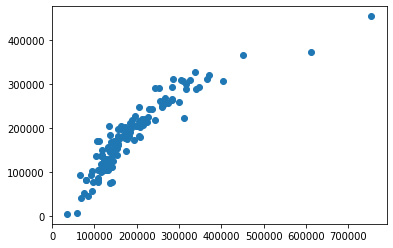

In [33]:
pred = model.predict(X_test)
plt.scatter(y_test, pred)

In [34]:
from sklearn import metrics

def print_evaluate(true, predicted):
  mae = metrics.mean_absolute_error(true, predicted)
  mse = metrics.mean_squared_error(true, predicted)
  rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
  r2_square = metrics.r2_score(true, predicted)
  
  print('MAE : ', mae)
  print('MSE : ', mse)
  print('RMSE : ', rmse)
  print('R2 Square : ', r2_square)

print_evaluate(y_test, pred)

MAE :  23794.14269597338
MSE :  1754358902.586029
RMSE :  41885.06777583186
R2 Square :  0.80798642166732


In [35]:
df_results = pd.concat([y_test.reset_index(), pd.DataFrame(pred)], axis=1)
df_results

,index,SalePrice,0
0,892,154500,155918.012756
1,1105,325000,308343.211554
2,413,115000,109925.280172
3,522,159000,176015.061794
4,1036,315500,299781.721455
...,...,...,...
141,526,132000,119118.906907
142,101,178000,185965.751837
143,1092,136500,183903.421321
144,411,145000,140071.706967


# Label transformation

In [36]:
import scipy.stats as st

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


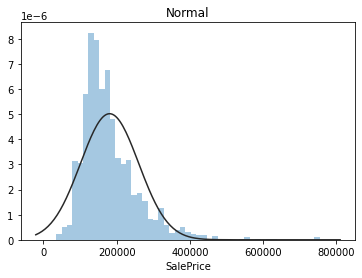

In [37]:
plt.figure(2); plt.title('Normal')
sns.distplot(df_processed['SalePrice'], kde=False, fit=st.norm)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


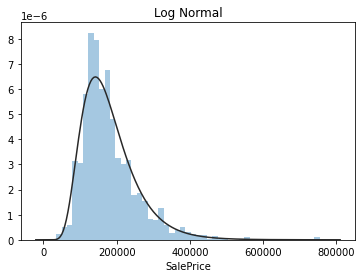

In [38]:
plt.figure(3); plt.title('Log Normal')
sns.distplot(df_processed['SalePrice'], kde=False, fit=st.lognorm)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


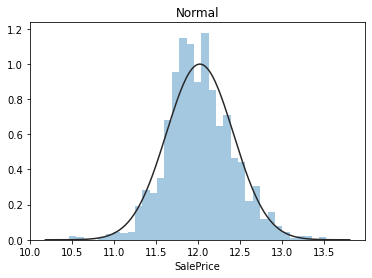

In [39]:
plt.figure(3); plt.title('Normal')
sns.distplot(np.log(df_processed['SalePrice']), kde=False, fit=st.norm)

In [40]:
model = Lasso()
model = model.fit(X_train, np.log(y_train))

In [41]:
pred = np.exp(model.predict(X_test))

In [42]:
print_evaluate(y_test, pred)

MAE :  21617.328358371098
MSE :  1345501205.1928196
RMSE :  36681.07420990857
R2 Square :  0.8527356627659387


# MLP

# Data Preprocessing

In [43]:
df_processed

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [44]:
X = df_processed[df_feature[-31:-1].index.tolist()]
y = df_processed['SalePrice']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [46]:
from sklearn.preprocessing import MinMaxScaler
# x = (x - min(columns)) / (max(columns)-min(columns)) --> x=min이면 0, max면 1
min_max_scaler = MinMaxScaler()
X_train.shape

(1314, 30)

In [47]:
min_max_scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [48]:
scaled_X_train = min_max_scaler.transform(X_train)
scaled_X_test = min_max_scaler.transform(X_test)

# y값 Scaling

In [49]:
y_min_max_scaler = MinMaxScaler()

In [50]:
y_train.shape # --> (1314, 1)

(1314,)

In [51]:
y_min_max_scaler.fit(np.array(y_train).reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [52]:
scaled_y_train = y_min_max_scaler.transform(np.array(y_train).reshape(-1, 1))
scaled_y_test = y_min_max_scaler.transform(np.array(y_test).reshape(-1, 1))
scaled_y_train.shape, scaled_y_test.shape

((1314, 1), (146, 1))

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
      keras.Input(shape=X_train.shape[-1]),
      layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(1.0))
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(loss="mse", optimizer="adam")
model.fit(scaled_X_train, scaled_y_train, batch_size=1, epochs=30)

Epoch 1/30
1314/1314 [==============================] - 1s 757us/step - loss: 0.8213
Epoch 2/30
1314/1314 [==============================] - 1s 795us/step - loss: 0.0157
Epoch 3/30
1314/1314 [==============================] - 1s 716us/step - loss: 0.0157
Epoch 4/30
1314/1314 [==============================] - 1s 737us/step - loss: 0.0157
Epoch 5/30
1314/1314 [==============================] - 1s 722us/step - loss: 0.0157
Epoch 6/30
1314/1314 [==============================] - 1s 747us/step - loss: 0.0157
Epoch 7/30
1314/1314 [==============================] - 1s 715us/step - loss: 0.0157
Epoch 8/30
1314/1314 [==============================] - 1s 723us/step - loss: 0.0157
Epoch 9/30
1314/1314 [==============================] - 1s 736us/step - loss: 0.0157
Epoch 10/30
1314/1314 [==============================] - 1s 745us/step - loss: 0.0157
Epoch 11/30
1314/1314 [==============================] - 1s 721us/step - loss: 0.0157
Epoch 12/30
1314/1314 [==============================] - 1s 737

In [55]:
scaled_pred = model.predict(scaled_X_test)
pred_y = y_min_max_scaler.inverse_transform(scaled_pred)
print_evaluate(y_test, pred_y)

MAE :  65322.879922945205
MSE :  9153198462.67224
RMSE :  95672.34951997489
R2 Square :  -0.0018123357861183909


# Add layers

In [56]:
model = keras.Sequential(
    [
      keras.Input(shape=scaled_X_train.shape[-1]),
      layers.Dense(96, activation='relu'),
      layers.Dense(48, activation='relu'),
      layers.Dense(1),
     
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 96)                2976      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                4656      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 49        
Total params: 7,681
Trainable params: 7,681
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss="mse", optimizer="adam")
model.fit(scaled_X_train, scaled_y_train, batch_size=2, epochs=30, validation_split=0.1) # validation_split : 검증한번더 한다, loss와 val_loss 비교 후 val_loss가 다시 커지면 overfitting이 일어난다.

Epoch 1/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 2/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 3/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 4/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 6/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 7/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 9.8080e-04
Epoch 10/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.

In [58]:
scaled_pred = model.predict(scaled_X_test)
pred_y = y_min_max_scaler.inverse_transform(scaled_pred)

In [59]:
print_evaluate(y_test, pred_y)

MAE :  18567.68049015411
MSE :  856202433.393214
RMSE :  29260.936987615656
R2 Square :  0.9062891334431968


# Early-stopping

In [60]:
model = keras.Sequential(
    [
      keras.Input(shape=scaled_X_train.shape[-1]),
      layers.Dense(96, activation='relu'),
      layers.Dense(48, activation='relu'),
      layers.Dense(1),
     
    ]
)

model.compile(loss="mse", optimizer="adam")

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7) # 7회 이내에 더 작은 val_loss값이 나오지 않으면 학습종료

model.fit(scaled_X_train, scaled_y_train, batch_size=2, epochs=30, callbacks=[early_stopping_callback], validation_split = 0.1)

Epoch 1/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 2/30
591/591 [==============================] - 1s 996us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 3/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 4/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 6/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 8/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 10/30
591/591 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.00

# K-fold Cross Validation

In [61]:
X.shape, y.shape

((1460, 30), (1460,))

In [62]:
K = 10
data_size = int(len(X)/ K)
data_size

146

In [63]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = K)

# data preprocessing
x_min_max_scaler = MinMaxScaler()
x_min_max_scaler.fit(X)
scaled_X = x_min_max_scaler.transform(X)

y_min_max_scaler = MinMaxScaler()
y_min_max_scaler.fit(np.array(y).reshape(-1, 1))
scaled_y = y_min_max_scaler.transform(np.array(y).reshape(-1, 1))

scaled_X.shape, scaled_y.shape

((1460, 30), (1460, 1))

# X, y data

In [64]:
NUM_FEATURES = len(df_feature) - 1
print(NUM_FEATURES)

60


In [65]:
X = df_processed[df_feature[-NUM_FEATURES-1:-1].index.tolist()]
y = df_processed['SalePrice']

In [66]:
y = np.array(y).reshape(-1,1)

In [67]:
# 최종 전처리된 데이터셋
X.shape, y.shape

((1460, 60), (1460, 1))

In [68]:
# save numpy data
with open('X.npy', 'wb') as f:
  np.save(f, X)

with open('y.npy', 'wb') as f:
  np.save(f, y)

with open('scaled_X.npy', 'wb') as f:
  np.save(f, scaled_X)

with open('scaled_y.npy', 'wb') as f:
  np.save(f, scaled_y)

In [69]:
# data preprocessing
x_min_max_scaler = MinMaxScaler()
x_min_max_scaler.fit(X)
scaled_X = x_min_max_scaler.transform(X)

y_min_max_scaler = MinMaxScaler()
y_min_max_scaler.fit(y)
scaled_y = y_min_max_scaler.transform(y)

scaled_X.shape, scaled_y.shape

((1460, 60), (1460, 1))

# Linear Regression(Lasso)

In [70]:
rmses = []
for train_index, test_index in kf.split(scaled_X):

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model = Lasso()
  model = model.fit(scaled_X_train, scaled_y_train)

  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('-----------------------')
  #break


  rmses.append(rmse)

print("average rmse : ", rmse)

68479.61848137801
-----------------------
80011.92820033105
-----------------------
79275.65958882873
-----------------------
82868.15912800275
-----------------------
96386.20490927555
-----------------------
76808.56629102639
-----------------------
72198.44861652121
-----------------------
71213.04254017191
-----------------------
90347.61467595294
-----------------------
72613.27897372228
-----------------------
average rmse :  72613.27897372228


# Decision Tree

In [71]:
from sklearn.tree import DecisionTreeRegressor

In [72]:
rmses = []
for train_index, test_index in kf.split(scaled_X):

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model = DecisionTreeRegressor(random_state=0)
  model = model.fit(scaled_X_train, scaled_y_train)

  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('-----------------------')
  #break

  rmses.append(rmse)

print("average rmse : ", rmse)

30399.757328562086
-----------------------
39262.00048244564
-----------------------
31348.02105259905
-----------------------
45609.41761613818
-----------------------
42668.42060694013
-----------------------
34194.276779042724
-----------------------
33546.08553058073
-----------------------
35528.465214938704
-----------------------
59407.585043958294
-----------------------
37735.24464250168
-----------------------
average rmse :  37735.24464250168


# Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
rmses = []
for train_index, test_index in kf.split(scaled_X):

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model = RandomForestRegressor(random_state=0)
  model = model.fit(scaled_X_train, scaled_y_train)

  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('-----------------------')
  #break

  rmses.append(rmse)

print("average rmse : ", rmse)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


25159.509083136116
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


27278.945783727027
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


22064.962825420196
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


40682.7576830191
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


32543.34638355806
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


26678.57878570247
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


24411.059545876644
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


23138.959475267948
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


43141.505098849804
-----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


26895.596395392888
-----------------------
average rmse :  26895.596395392888


# AdaBoost

In [75]:
from sklearn.ensemble import AdaBoostRegressor

In [76]:
rmses =[]
for train_index, test_index in kf.split(scaled_X):

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model = AdaBoostRegressor(random_state=0)
  model = model.fit(scaled_X_train, scaled_y_train)

  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('-----------------------')
  #break

  rmses.append(rmse)

print("average rmse : ", rmse)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


29216.343827541197
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33282.117102484
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


29149.232825948846
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


44189.177644650124
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


39012.2510911128
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33095.41790740461
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


31417.10861322294
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


30933.03236129543
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


46328.51256772787
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34212.22304763838
-----------------------
average rmse :  34212.22304763838


# MLP

In [77]:
rmses =[]
for train_index, test_index in kf.split(scaled_X):

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model = keras.Sequential(
    [
      keras.Input(shape=scaled_X_train.shape[-1]),
      layers.Dense(96, activation='relu'),
      layers.Dense(48, activation='relu'),
      layers.Dense(1),
     
    ]
  )
  model.compile(loss="mse", optimizer="adam")

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7) 
  model.fit(scaled_X_train, scaled_y_train,
            batch_size=2, epochs=30,
            callbacks = [early_stopping_callback], validation_split=0.05) # validation_split : 검증한번더 한다, loss와 val_loss 비교 후 val_loss가 다시 커지면 overfitting이 일어난다.

  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('-----------------------')
  #break

  rmses.append(rmse)

print("average rmse : ", rmse)

Epoch 1/30
624/624 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 2/30
624/624 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 3/30
624/624 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 4/30
624/624 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/30
624/624 [==============================] - 1s 994us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 6/30
624/624 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 7/30
624/624 [==============================] - 1s 992us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 8/30
624/624 [==============================] - 1s 985us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/30
624/624 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/30
624/624 [==============================] - 1s 969us/step - loss: 0.0013 - val_loss

# XGBoost

In [78]:
from xgboost import XGBRegressor

In [79]:
rmses =[]
for train_index, test_index in kf.split(scaled_X):

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model = XGBRegressor(n_estimators=300)
  model = model.fit(scaled_X_train, scaled_y_train)

  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('-----------------------')
  #break

  rmses.append(rmse)

print("average rmse : ", rmse)

[07:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
20119.145009285483
-----------------------
[07:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23169.38252926395
-----------------------
[07:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
21690.38435914477
-----------------------
[07:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
39523.493638339394
-----------------------
[07:19:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
29233.15572183937
-----------------------
[07:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23923.69793328054
--------

# Submission

In [80]:
df_test = pd.read_csv("test.csv")

In [81]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [82]:
df_missing.index.tolist()

['PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'LotFrontage',
 'GarageCond',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'BsmtExposure',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtCond',
 'BsmtQual',
 'MasVnrArea',
 'MasVnrType',
 'Electrical']

In [83]:
# 1. remove missing data feature
df_test = df_test.drop(df_missing.index.tolist(), axis=1)

In [84]:
df_test

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,602.0,0.0,324.0,926.0,GasA,Ex,Y,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,2.0,470.0,Y,360,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,Gd,TA,PConc,263.0,0.0,1017.0,1280.0,GasA,Ex,Y,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,2.0,506.0,Y,0,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,0.0,0.0,546.0,546.0,GasA,Gd,Y,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,0.0,0.0,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,252.0,0.0,294.0,546.0,GasA,TA,Y,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,1.0,286.0,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,1224.0,0.0,0.0,1224.0,GasA,Ex,Y,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,2.0,576.0,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,TA,TA,PConc,337.0,0.0,575.0,912.0,GasA,TA,Y,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,0.0,0.0,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


In [85]:
# missing data가 있는지 재확인
df_test.isnull().sum()

Id               0
MSSubClass       0
MSZoning         4
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         1
SaleCondition    0
Length: 61, dtype: int64

In [86]:
# 2. category -> number
category_maps

[{'C (all)': 3, 'FV': 4, 'RH': 5, 'RL': 1, 'RM': 2},
 {'Grvl': 2, 'Pave': 1},
 {'IR1': 2, 'IR2': 3, 'IR3': 4, 'Reg': 1},
 {'Bnk': 2, 'HLS': 4, 'Low': 3, 'Lvl': 1},
 {'AllPub': 1, 'NoSeWa': 2},
 {'Corner': 3, 'CulDSac': 4, 'FR2': 2, 'FR3': 5, 'Inside': 1},
 {'Gtl': 1, 'Mod': 2, 'Sev': 3},
 {'Blmngtn': 22,
  'Blueste': 25,
  'BrDale': 23,
  'BrkSide': 9,
  'ClearCr': 20,
  'CollgCr': 1,
  'Crawfor': 3,
  'Edwards': 16,
  'Gilbert': 18,
  'IDOTRR': 14,
  'MeadowV': 15,
  'Mitchel': 5,
  'NAmes': 12,
  'NPkVill': 21,
  'NWAmes': 7,
  'NoRidge': 4,
  'NridgHt': 11,
  'OldTown': 8,
  'SWISU': 24,
  'Sawyer': 10,
  'SawyerW': 13,
  'Somerst': 6,
  'StoneBr': 19,
  'Timber': 17,
  'Veenker': 2},
 {'Artery': 4,
  'Feedr': 2,
  'Norm': 1,
  'PosA': 8,
  'PosN': 3,
  'RRAe': 5,
  'RRAn': 7,
  'RRNe': 9,
  'RRNn': 6},
 {'Artery': 2,
  'Feedr': 4,
  'Norm': 1,
  'PosA': 6,
  'PosN': 5,
  'RRAe': 8,
  'RRAn': 7,
  'RRNn': 3},
 {'1Fam': 1, '2fmCon': 2, 'Duplex': 3, 'Twnhs': 5, 'TwnhsE': 4},
 {'1.5Fin

In [87]:
def category_to_number(x, category_maps, feature_name):
  if x[feature_name] in category_map:
    return category_map[x[feature_name]]
  else:
    0

In [88]:
category_maps

[{'C (all)': 3, 'FV': 4, 'RH': 5, 'RL': 1, 'RM': 2},
 {'Grvl': 2, 'Pave': 1},
 {'IR1': 2, 'IR2': 3, 'IR3': 4, 'Reg': 1},
 {'Bnk': 2, 'HLS': 4, 'Low': 3, 'Lvl': 1},
 {'AllPub': 1, 'NoSeWa': 2},
 {'Corner': 3, 'CulDSac': 4, 'FR2': 2, 'FR3': 5, 'Inside': 1},
 {'Gtl': 1, 'Mod': 2, 'Sev': 3},
 {'Blmngtn': 22,
  'Blueste': 25,
  'BrDale': 23,
  'BrkSide': 9,
  'ClearCr': 20,
  'CollgCr': 1,
  'Crawfor': 3,
  'Edwards': 16,
  'Gilbert': 18,
  'IDOTRR': 14,
  'MeadowV': 15,
  'Mitchel': 5,
  'NAmes': 12,
  'NPkVill': 21,
  'NWAmes': 7,
  'NoRidge': 4,
  'NridgHt': 11,
  'OldTown': 8,
  'SWISU': 24,
  'Sawyer': 10,
  'SawyerW': 13,
  'Somerst': 6,
  'StoneBr': 19,
  'Timber': 17,
  'Veenker': 2},
 {'Artery': 4,
  'Feedr': 2,
  'Norm': 1,
  'PosA': 8,
  'PosN': 3,
  'RRAe': 5,
  'RRAn': 7,
  'RRNe': 9,
  'RRNn': 6},
 {'Artery': 2,
  'Feedr': 4,
  'Norm': 1,
  'PosA': 6,
  'PosN': 5,
  'RRAe': 8,
  'RRAn': 7,
  'RRNn': 3},
 {'1Fam': 1, '2fmCon': 2, 'Duplex': 3, 'Twnhs': 5, 'TwnhsE': 4},
 {'1.5Fin

In [89]:
for i, feature_name in enumerate(categorical):
  print(i)
  rank_feature_name = feature_name + '_rank'
  print(feature_name, '-->', rank_feature_name)

  category_map = category_maps[i]
  print(category_map)

  df_test[rank_feature_name] = df_test.apply(lambda x: category_to_number(x, category_map, feature_name), axis=1)

0
MSZoning --> MSZoning_rank
{'RL': 1, 'RM': 2, 'C (all)': 3, 'FV': 4, 'RH': 5}
1
Street --> Street_rank
{'Pave': 1, 'Grvl': 2}
2
LotShape --> LotShape_rank
{'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}
3
LandContour --> LandContour_rank
{'Lvl': 1, 'Bnk': 2, 'Low': 3, 'HLS': 4}
4
Utilities --> Utilities_rank
{'AllPub': 1, 'NoSeWa': 2}
5
LotConfig --> LotConfig_rank
{'Inside': 1, 'FR2': 2, 'Corner': 3, 'CulDSac': 4, 'FR3': 5}
6
LandSlope --> LandSlope_rank
{'Gtl': 1, 'Mod': 2, 'Sev': 3}
7
Neighborhood --> Neighborhood_rank
{'CollgCr': 1, 'Veenker': 2, 'Crawfor': 3, 'NoRidge': 4, 'Mitchel': 5, 'Somerst': 6, 'NWAmes': 7, 'OldTown': 8, 'BrkSide': 9, 'Sawyer': 10, 'NridgHt': 11, 'NAmes': 12, 'SawyerW': 13, 'IDOTRR': 14, 'MeadowV': 15, 'Edwards': 16, 'Timber': 17, 'Gilbert': 18, 'StoneBr': 19, 'ClearCr': 20, 'NPkVill': 21, 'Blmngtn': 22, 'BrDale': 23, 'SWISU': 24, 'Blueste': 25}
8
Condition1 --> Condition1_rank
{'Norm': 1, 'Feedr': 2, 'PosN': 3, 'Artery': 4, 'RRAe': 5, 'RRNn': 6, 'RRAn': 7, 'PosA

In [90]:
df_test

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,...,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,5.0,1,1,1,1.0,1,1,12,2,1,1,2,1,1,1.0,1.0,2,1,2,1,3,1,2.0,1.0,1,1.0,1
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,...,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,1.0,1,2,1,1.0,3,1,12,1,1,1,2,2,1,3.0,6.0,2,1,2,1,3,1,1.0,1.0,1,1.0,1
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,...,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,2,1,2.0,1.0,1,1.0,1
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,602.0,0.0,324.0,926.0,GasA,Ex,Y,926,678,0,1604,0.0,0.0,2,...,470.0,Y,360,36,0,0,0,0,0,6,2010,WD,Normal,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,1,1,1.0,1.0,1,1.0,1
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,Gd,TA,PConc,263.0,0.0,1017.0,1280.0,GasA,Ex,Y,1280,0,0,1280,0.0,0.0,2,...,506.0,Y,0,82,0,0,144,0,0,1,2010,WD,Normal,1.0,1,2,4,1.0,1,1,19,1,1,4,2,1,1,4.0,4.0,1,1,1,1,1,1,1.0,1.0,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,0.0,0.0,546.0,546.0,GasA,Gd,Y,546,546,0,1092,0.0,0.0,1,...,0.0,Y,0,0,0,0,0,0,0,6,2006,WD,Normal,2.0,1,1,1,1.0,1,1,15,1,1,5,1,1,1,7.0,7.0,2,1,2,1,2,1,2.0,1.0,1,1.0,1
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,252.0,0.0,294.0,546.0,GasA,TA,Y,546,546,0,1092,0.0,0.0,1,...,286.0,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml,2.0,1,1,1,1.0,1,1,15,1,1,4,1,1,1,7.0,7.0,2,1,2,1,3,1,2.0,1.0,1,1.0,2
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,1224.0,0.0,0.0,1224.0,GasA,Ex,Y,1224,0,0,1224,1.0,0.0,1,...,576.0,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml,1.0,1,1,1,1.0,1,1,5,1,1,1,2,1,1,1.0,1.0,2,1,2,1,1,1,2.0,1.0,1,1.0,2
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,TA,TA,PConc,337.0,0.0,575.0,912.0,GasA,TA,Y,970,0,0,970,0.0,1.0,1,...,0.0,Y,80,32,0,0,0,0,700,7,2006,W

In [91]:
df_processed_test = df_test[rank_features + numeric]

In [92]:
df_processed_test

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,5.0,1,1,1,1.0,1,1,12,2,1,1,2,1,1,1.0,1.0,2,1,2,1,3,1,2.0,1.0,1,1.0,1,20,11622,5,6,1961,1961,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,1.0,1,2,1,1.0,3,1,12,1,1,1,2,2,1,3.0,6.0,2,1,2,1,3,1,1.0,1.0,1,1.0,1,20,14267,6,6,1958,1958,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,2,1,2.0,1.0,1,1.0,1,60,13830,5,5,1997,1998,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,3,2010
3,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,1,1,1.0,1.0,1,1.0,1,60,9978,6,6,1998,1998,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,6,2010
4,1.0,1,2,4,1.0,1,1,19,1,1,4,2,1,1,4.0,4.0,1,1,1,1,1,1,1.0,1.0,1,1.0,1,120,5005,8,5,1992,1992,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.0,1,1,1,1.0,1,1,15,1,1,5,1,1,1,7.0,7.0,2,1,2,1,2,1,2.0,1.0,1,1.0,1,160,1936,4,7,1970,1970,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0.0,0.0,0,0,0,0,0,0,0,6,2006
1455,2.0,1,1,1,1.0,1,1,15,1,1,4,1,1,1,7.0,7.0,2,1,2,1,3,1,2.0,1.0,1,1.0,2,160,1894,4,5,1970,1970,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1.0,286.0,0,24,0,0,0,0,0,4,2006
1456,1.0,1,1,1,1.0,1,1,5,1,1,1,2,1,1,1.0,1.0,2,1,2,1,1,1,2.0,1.0,1,1.0,2,20,20000,5,7,1960,1996,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,2.0,576.0,474,0,0,0,0,0,0,9,2006
1457,1.0,1,1,1,1.0,1,1,5,1,1,1,5,1,1,4.0,3.0,2,1,1,1,3,1,2.0,1.0,1,1.0,1,85,10441,5,5,1992,1992,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,0.0,0.0,80,32,0,0,0,0,700,7,2006


In [93]:
df_processed_test.columns

Index(['MSZoning_rank', 'Street_rank', 'LotShape_rank', 'LandContour_rank',
       'Utilities_rank', 'LotConfig_rank', 'LandSlope_rank',
       'Neighborhood_rank', 'Condition1_rank', 'Condition2_rank',
       'BldgType_rank', 'HouseStyle_rank', 'RoofStyle_rank', 'RoofMatl_rank',
       'Exterior1st_rank', 'Exterior2nd_rank', 'ExterQual_rank',
       'ExterCond_rank', 'Foundation_rank', 'Heating_rank', 'HeatingQC_rank',
       'CentralAir_rank', 'KitchenQual_rank', 'Functional_rank',
       'PavedDrive_rank', 'SaleType_rank', 'SaleCondition_rank', 'MSSubClass',
       'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'Scree

In [94]:
df_processed_test = df_processed_test[df_feature[-NUM_FEATURES-1:-1].index.tolist()]

In [95]:
df_processed_test.columns

Index(['Foundation_rank', 'HeatingQC_rank', 'ExterQual_rank',
       'CentralAir_rank', 'PavedDrive_rank', 'HouseStyle_rank',
       'Exterior2nd_rank', 'Neighborhood_rank', 'KitchenAbvGr',
       'EnclosedPorch', 'ExterCond_rank', 'Exterior1st_rank', 'MSZoning_rank',
       'KitchenQual_rank', 'BldgType_rank', 'Functional_rank', 'Heating_rank',
       'MSSubClass', 'OverallCond', 'Condition1_rank', 'Street_rank', 'YrSold',
       'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'Utilities_rank',
       'BsmtFinSF2', 'Condition2_rank', 'RoofMatl_rank', '3SsnPorch', 'MoSold',
       'LandSlope_rank', 'SaleType_rank', 'LandContour_rank', 'PoolArea',
       'LotConfig_rank', 'ScreenPorch', 'SaleCondition_rank', 'RoofStyle_rank',
       'BedroomAbvGr', 'BsmtUnfSF', 'BsmtFullBath', 'LotArea', 'LotShape_rank',
       'HalfBath', 'OpenPorchSF', '2ndFlrSF', 'WoodDeckSF', 'BsmtFinSF1',
       'Fireplaces', 'YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath',
       '1stFlrSF', 'TotalBsmtSF', 'Gar

In [96]:
scaled_X_test = x_min_max_scaler.transform(df_processed_test)

In [97]:
scaled_X_test.shape

(1459, 60)

In [98]:
scaled_X_test

array([[0.2       , 0.5       , 0.33333333, ..., 0.25      , 0.10587792,
        0.44444444],
       [0.2       , 0.5       , 0.33333333, ..., 0.25      , 0.1874529 ,
        0.55555556],
       [0.        , 0.25      , 0.33333333, ..., 0.5       , 0.24397136,
        0.44444444],
       ...,
       [0.2       , 0.        , 0.33333333, ..., 0.5       , 0.16767144,
        0.44444444],
       [0.        , 0.5       , 0.33333333, ..., 0.        , 0.11981914,
        0.44444444],
       [0.        , 0.        , 0.33333333, ..., 0.75      , 0.31386586,
        0.66666667]])

In [99]:
# predict 
pred = model.predict(scaled_X_test).reshape((-1,1))
pred = y_min_max_scaler.inverse_transform(pred)

In [100]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [101]:
pred

array([[118003.88],
       [157929.78],
       [181756.06],
       ...,
       [180693.61],
       [124154.04],
       [234959.3 ]], dtype=float32)

In [102]:
df_submission = pd.DataFrame(columns=['Id', 'SalePrice'])

In [103]:
df_submission

,Id,SalePrice


In [104]:
np.arange(1461, 1463)

array([1461, 1462])

In [105]:
df_submission['Id'] = np.arange(1461, 2919 +1)

In [106]:
df_submission

,Id,SalePrice
0,1461,NaN
1,1462,NaN
2,1463,NaN
3,1464,NaN
4,1465,NaN
...,...,...
1454,2915,NaN
1455,2916,NaN
1456,2917,NaN
1457,2918,NaN


In [107]:
df_submission['SalePrice'] = pred

In [108]:
df_submission

,Id,SalePrice
0,1461,118003.882812
1,1462,157929.781250
2,1463,181756.062500
3,1464,184412.593750
4,1465,183726.125000
...,...,...
1454,2915,77995.093750
1455,2916,83047.640625
1456,2917,180693.609375
1457,2918,124154.039062


In [109]:
df_submission.to_csv('submission_xgboost.csv', index=False)